# cassava leaf disease categorization using deep neural network 

In [109]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import pandas as pd

In [110]:
#!pip install tensorflow-gpu

In [152]:
BATCH_SIZE = 32
IMAGE_SIZE = 128
CHANNELS = 3
EPOCHS = 5

### Import data into tensorflow dataset object

In [153]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2587 files belonging to 5 classes.


In [154]:
#This will show the classes names that exists
class_names = dataset.class_names
class_names

['CBB', 'CBSD', 'CGM', 'CMD', 'HEALTHY']

In [155]:
dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

(32, 128, 128, 3)
[2 3 2 3 4 3 2 3 4 1 0 3 4 3 1 4 3 3 4 0 4 0 1 3 1 1 3 2 0 1 1 0]


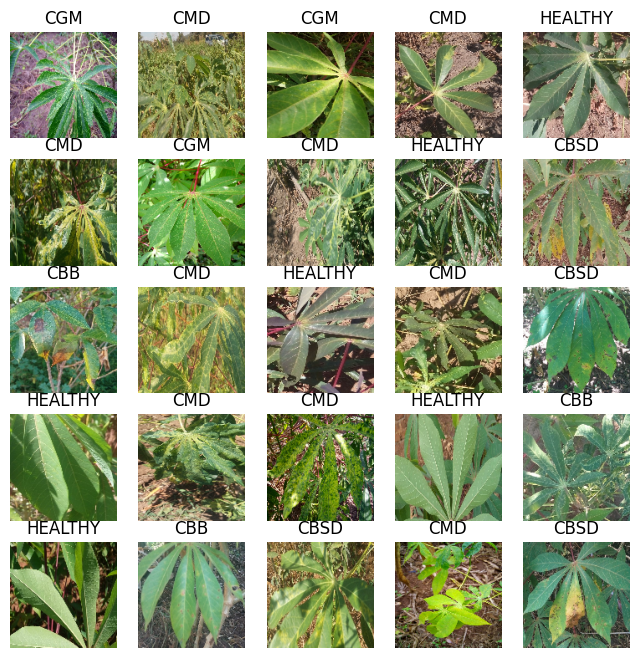

In [156]:
plt.figure(figsize=(8,8))
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    
    #ploting images
    for i in range(25):
        ax = plt.subplot(5,5,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        #plt.scatter(image_batch[i], class_names[labels_batch[i]], c='blue')
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [158]:
names = []
s = []
for image_batch, labels_batch in dataset.take(1):
    #print(image_batch.shape)
    print(labels_batch.numpy())
 
    for i in range(32):
        data = pd.DataFrame(labels_batch)
        names = class_names[labels_batch[i]]
        s.append(names)
        print(s[i])
 

       

[2 3 1 2 3 1 0 3 3 3 1 3 3 3 0 2 0 0 1 1 1 1 1 3 4 3 4 3 1 2 2 3]
CGM
CMD
CBSD
CGM
CMD
CBSD
CBB
CMD
CMD
CMD
CBSD
CMD
CMD
CMD
CBB
CGM
CBB
CBB
CBSD
CBSD
CBSD
CBSD
CBSD
CMD
HEALTHY
CMD
HEALTHY
CMD
CBSD
CGM
CGM
CMD


In [159]:
len(s)

32

In [160]:
len(data)

32

In [161]:
data['names'] = s

In [162]:
data

,0,names
0,2,CGM
1,3,CMD
2,1,CBSD
3,2,CGM
4,3,CMD
5,1,CBSD
6,0,CBB
7,3,CMD
8,3,CMD
9,3,CMD


In [163]:
data.rename(columns={0:'id'}, inplace = True)

In [164]:
data.head()


,id,names
0,2,CGM
1,3,CMD
2,1,CBSD
3,2,CGM
4,3,CMD


In [166]:
import numpy as np
np.unique(data['id'])

array([0, 1, 2, 3, 4])

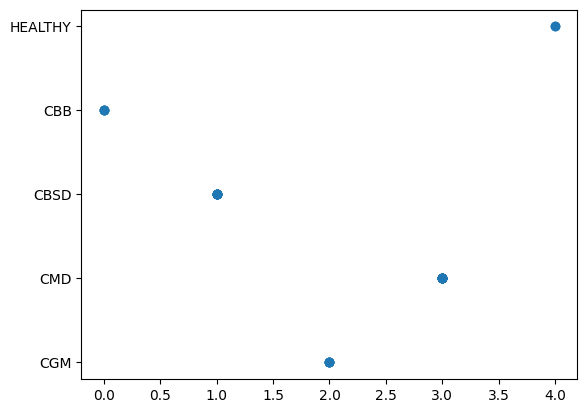

In [167]:
plt.scatter(data.id, data.names)

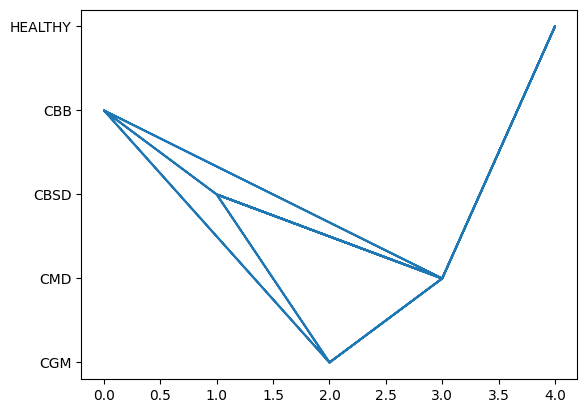

In [168]:
plt.plot(data.id, data.names)

In [169]:
len(dataset)

81

In [170]:
train_size = 0.8
len(dataset)*train_size

64.8

In [171]:
train_ds = dataset.take(20)
len(train_ds)

20

In [172]:
test_ds = dataset.skip(20)
len(test_ds)

61

In [173]:
val_size=0.1
len(dataset)*val_size

8.1

In [174]:
val_ds = test_ds.take(2)
len(val_ds)

2

In [175]:
test_ds = test_ds.skip(2)
len(test_ds)

59

## Partitioning Data 

In [176]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [177]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [178]:
len(train_ds)

64

In [179]:
len(val_ds)

8

In [180]:
len(test_ds)

9

In [181]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [182]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [142]:
'''data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])'''

'data_augmentation = tf.keras.Sequential([\n  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),\n  layers.experimental.preprocessing.RandomRotation(0.2),\n])'

In [143]:
'''train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)
'''

'train_ds = train_ds.map(\n    lambda x, y: (data_augmentation(x, training=True), y)\n).prefetch(buffer_size=tf.data.AUTOTUNE)\n'

## Building the Model

In [187]:
input__shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input__shape)

In [188]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (32, 128, 128, 3)         0         
                                                                 
 conv2d_41 (Conv2D)          (32, 126, 126, 32)        896       
                                                                 
 max_pooling2d_41 (MaxPoolin  (32, 63, 63, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (32, 61, 61, 64)          18496     
                                                                 
 max_pooling2d_42 (MaxPoolin  (32, 30, 30, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (32, 28, 28, 64)        

In [189]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [190]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=5,)

Epoch 1/5
64/64 [==============================] - 79s 876ms/step - loss: 1.5469 - accuracy: 0.2896 - val_loss: 1.4700 - val_accuracy: 0.3984
Epoch 2/5
64/64 [==============================] - 51s 802ms/step - loss: 1.4422 - accuracy: 0.4048 - val_loss: 1.4273 - val_accuracy: 0.3828
Epoch 3/5
64/64 [==============================] - 49s 769ms/step - loss: 1.3618 - accuracy: 0.4580 - val_loss: 1.3457 - val_accuracy: 0.4102
Epoch 4/5
64/64 [==============================] - 51s 799ms/step - loss: 1.3445 - accuracy: 0.4575 - val_loss: 1.2748 - val_accuracy: 0.4766
Epoch 5/5
64/64 [==============================] - 49s 771ms/step - loss: 1.2860 - accuracy: 0.4790 - val_loss: 1.2167 - val_accuracy: 0.4922


## visualization of loss and accuracy

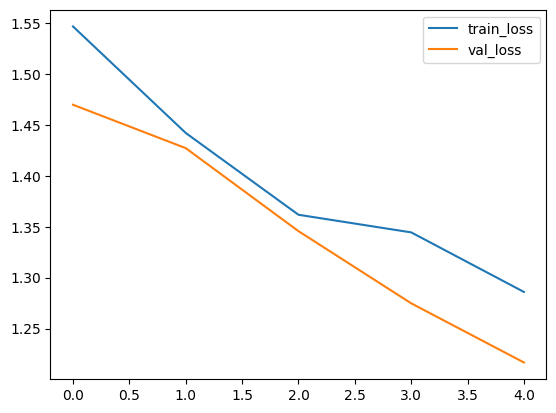

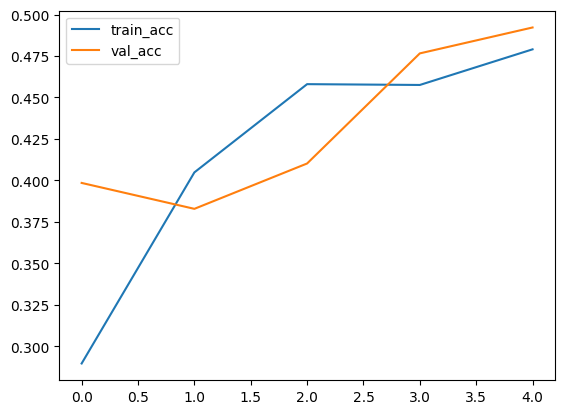

In [191]:

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()

In [192]:
scores = model.evaluate(test_ds)

9/9 [==============================] - 6s 260ms/step - loss: 1.2144 - accuracy: 0.5104


In [193]:
scores

[1.2143878936767578, 0.5104166865348816]

In [194]:
y_pred = model.predict(test_ds)

9/9 [==============================] - 2s 224ms/step


In [195]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

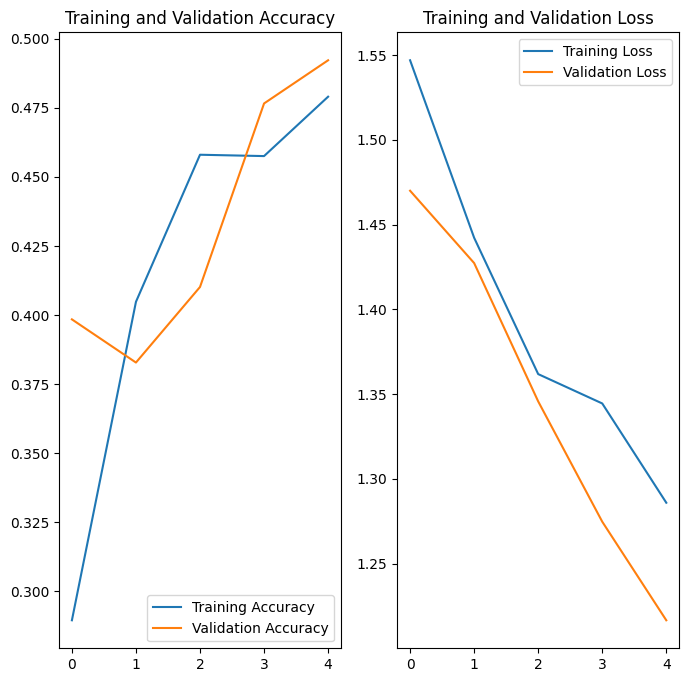

In [196]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Prediction of some data

first image to predict
actual label: CMD
1/1 [==============================] - 0s 345ms/step
3
predicted label: CMD


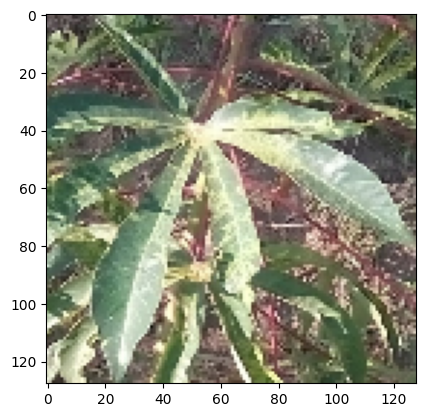

In [197]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print(np.argmax(batch_prediction[0]))
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [201]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 36ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 34ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 31ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 33ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 33ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 34ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 28ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 33ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 33ms/step


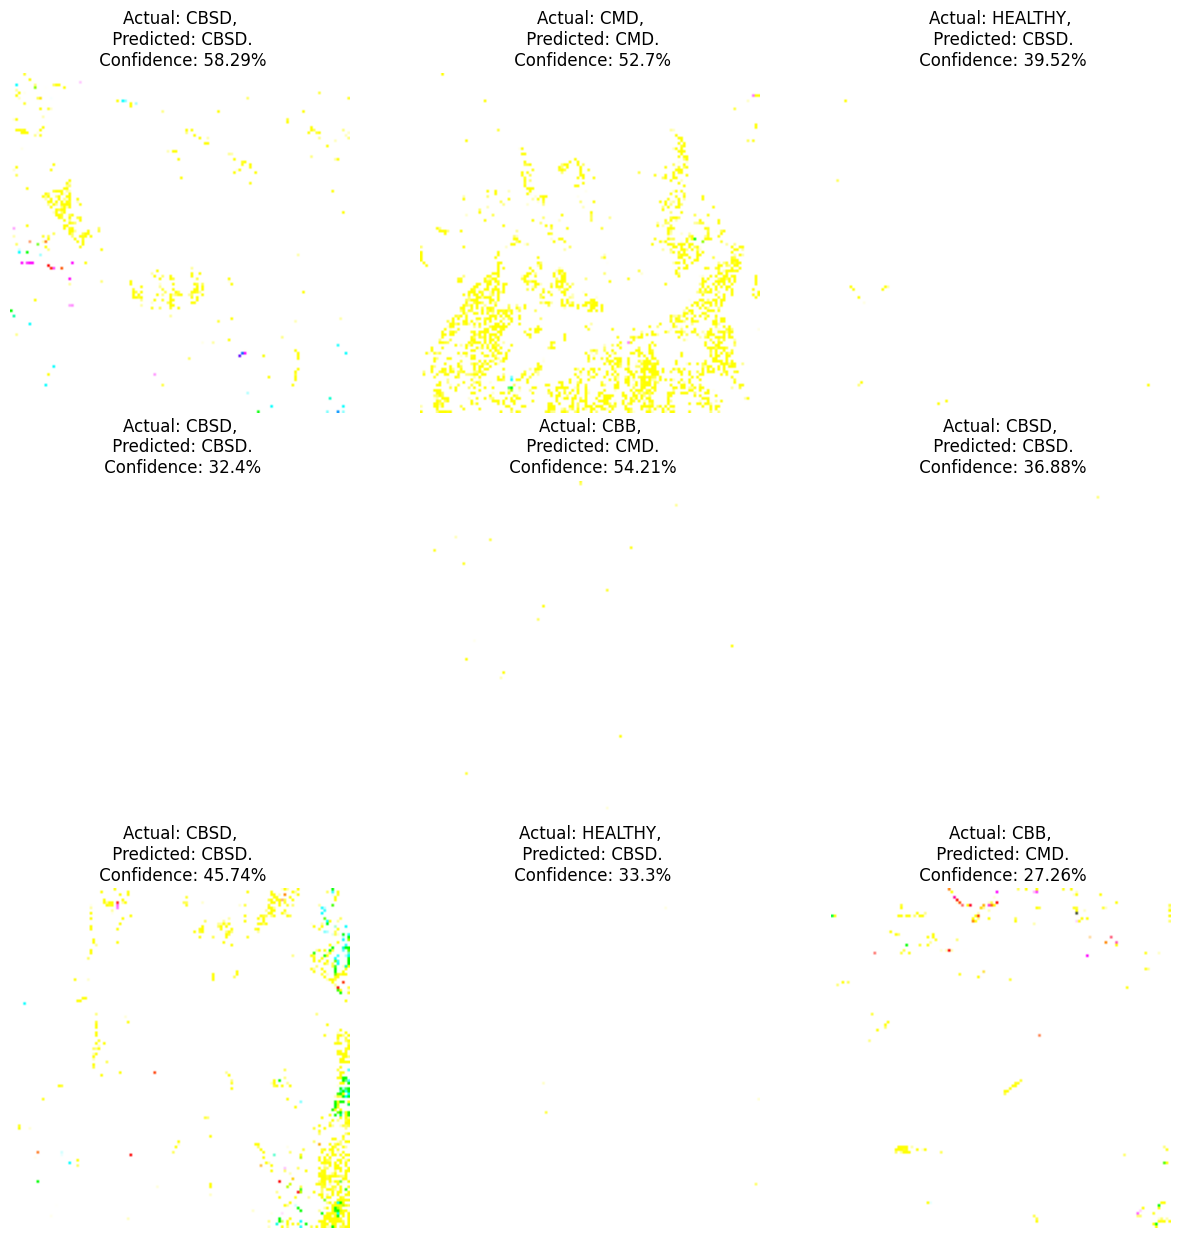

In [202]:
plt.figure(figsize=(15, 15))
for images, labels in val_ds:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[int(labels[i])] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
    break

### Saving the Model

Save model in h5 format so that there is just one file and we can upload that to GCP conveniently

In [205]:
model.save("cassava_output.h5")

In [ ]:
###################################

In [ ]:
####VGG16 restnet

In [ ]:
'''from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt'''

In [ ]:
'''# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False
  

  
  # useful for getting number of classes
folders = glob('/content/drive/MyDrive/train')
  

# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)'''



In [ ]:

'''from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/train',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

'''

In [ ]:
'''# fit the model
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)
'''

In [ ]:
'''# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# accuracies
plt.plot(r.history['acc'], label='train acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')'''